# Formula 1 Data Analysis and Modeling Project

Objective: 
* Predict the winner of a F1 driver championship 

Introduction: 
We will employ classification and regression methods to predict the winner of a F! driver championship. The project inolves the following procedures: 
* Data collection and cleaning 
* Data analysis 
* Modeling 

## Imports

In [1]:
import pandas as pd 
import numpy as np 
from dateutil.relativedelta import *
from sklearn import *
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LogisticRegression
from sklearn import svm
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.core.pylabtools import figsize

## Data collection and cleaning 

I collected the datasets on the Formula 1 championships from Kaggle - 
https://www.kaggle.com/rohanrao/formula-1-world-championship-1950-2020/code

I created the weather dataset, which was unavailable on Kaggle. Weather is important factor in racing, as wet conditions often disrupt the performance of the driver and the car. To generate the weather data, I iterated through wikipedia url links and scraped the weather conditions for each race. The collection of weather data can be viewed through here -> 

In [2]:
df_weather = pd.read_csv('weather.csv')
df_results = pd.read_csv('results.csv')
df_races = pd.read_csv('races.csv')
df_drivers = pd.read_csv('drivers.csv')
df_constructor_stand = pd.read_csv('constructor_standings.csv')

### Merging dataframes

In [3]:
#merge race and weather data 
cols_to_use = df_weather.columns.difference(df_races.columns).append(pd.Index(['url']))
df_1 = pd.merge(df_races, df_weather[cols_to_use], how = "inner", on = ['url']).drop(['Unnamed: 0', 'weather_det'], axis = 1)

In [4]:
#merge with results data
df_results = df_results.drop(['constructorId', 'number', 'positionText', 'positionOrder', 'laps', 'time', 'fastestLapSpeed'], axis = 1)
df_2 = pd.merge(df_1.add_suffix('_r'), df_results.add_suffix('_d'), how = "right", left_on = "raceId_r", right_on = "raceId_d")
df_2 = df_2.drop(['raceId_d'], axis = 1)

In [5]:
#merge driver data 
df_drivers = df_drivers.drop(['number', 'url', 'code', 'forename', 'surname'], axis = 1)
df_4 = pd.merge(df_drivers, df_2, how = "right", left_on = ['driverId'], right_on = ['driverId_d'])

In [6]:
#drop others
df_4 = df_4.drop(['statusId_d', 'fastestLap_d', 'driverId_d', 'weatherDetail_r', 'rank_d', 'url_r'], axis = 1)

In [7]:
#calculate age
df_4['dob'] = pd.to_datetime(df_4.dob)
df_4['date_r'] = pd.to_datetime(df_4.date_r)
df_4['age'] = df_4.apply(lambda x: relativedelta(x['date_r'], x['dob']).years, axis = 1)
df_4.drop(['dob', 'date_r'], axis = 1, inplace = True)

In [8]:
#create final dataframe for modeling 
df_final = df_4[['driverId', 'round_r', 'year_r', 'grid_d', 'position_d', 'points_d', 'age', 'weather_r', 'circuitId_r', 'nationality']]

In [9]:
#clean data 
df_final.fillna(0, inplace = True)
df_final = df_final[df_final['position_d']!="\\N"]
df_final['position_d'] = df_final['position_d'].astype('int')

/Users/rachelkindangen/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4317: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().fillna(


### Description of features and target

In [10]:
df_final.head()

,driverId,round_r,year_r,grid_d,position_d,points_d,age,weather_r,circuitId_r,nationality
0,1,1,2008,1,1,10.0,23,[],1,British
1,1,2,2008,9,5,4.0,23,['weather_cloudy'],2,British
2,1,3,2008,3,13,0.0,23,['weather_dry'],3,British
3,1,4,2008,5,3,6.0,23,['weather_warm'],4,British
4,1,5,2008,3,2,8.0,23,['weather_warm'],5,British


Quantitative features: 
* **round_r** = The round number of the Formula 1 championship. Formula 1 championships consists of several rounds hosted in different racing circuits. There are around 25 rounds in a single championship. 
* **year_r** = The year of the Formula 1 championship. Formula 1 championships are held anually. 
* **grid_d** = The position where the driver starts the official race. Grid position is determined during qualifying, where drivers compete to get the fastest lap. 
* **points_d** = The amount of racing points the driver has accumulated during that F1 season.
* **age** = Age of the driver

Qualitative features:
* **circuitId_r** = The circuit where the race was held. 
* **weather_r** = The weather conditions during the race 
* **nationality** = The nationality of the driver 

Target values: 
* **driverId** = Identification of the driver
* **position_d** = The racing standings for each driver, with 1 being the winner of the race. 

### Creating dummy variables

In [11]:
#Turning weather data into boolean values
cols = ['weather_warm', 'weather_cold', 'weather_dry', 'weather_wet', 'weather_cloudy']
for col in cols: 
    df_final[col] = df_final.apply(lambda x: 1 if 'col' in x['weather_r'] else 0, axis = 1)
df_final.drop('weather_r', inplace = True, axis = 1)

In [12]:
#Getting boolean values for circuitId and nationality of the driver 
df_dum = pd.get_dummies(df_final, columns = ['circuitId_r', 'nationality'] )

In [13]:
for col in df_dum.columns: 
    if 'nationality' in col and df_dum[col].sum() < 130:
        df_dum.drop(col, inplace = True, axis = 1)
    elif 'circuit' in col and df_dum[col].sum() < 60:
        df_dum.drop(col, inplace = True, axis = 1)
    else: 
        pass 

In [14]:
df = df_dum.copy()

## Data analysis

In [15]:
#correlation between milliseconds and year 
df_explore = pd.merge(df_results, df_races, how = "inner")
df_explore = df_explore[df_explore["milliseconds"] != '\\N']
df_explore["milliseconds"] = df_explore["milliseconds"].astype("int")
df_explore = df_explore.groupby(by = "year")['milliseconds'].mean().reset_index()

Text(0, 0.5, 'Average Race Time (Milliseconds)')

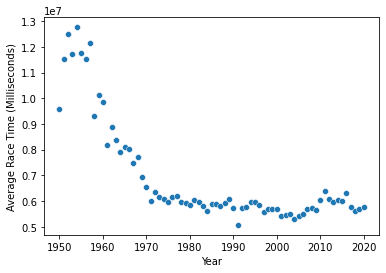

In [17]:
p = sns.scatterplot(x = "year", y = "milliseconds", data = df_explore)
p.set_xlabel("Year")
p.set_ylabel("Average Race Time (Milliseconds)")

The scatterplot reveals that as the years progressed, the average time required to complete a circuit by an F1 car decreased, indicating an increase in the performance of the car. The scatterplot's shape also implies that the performance of the F1 car grew exponentially. 

In [21]:
df_explore1 = df.groupby('year_r')['age'].mean().reset_index()

Text(0, 0.5, 'Average Age')

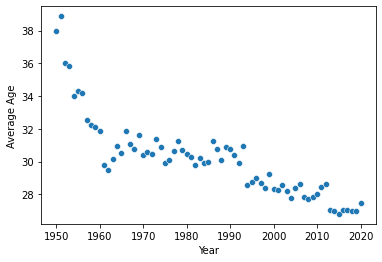

In [22]:
p = sns.scatterplot(x = "year_r", y = "age", data = df_explore1)
p.set_xlabel("Year")
p.set_ylabel("Average Age")

The scatterplot reveals that the average age of an F1 driver declined as the years progressed. 

In [ ]:
#proportion of wins vs grid position

In [23]:
from IPython.display import Image

In [24]:
Image(url="DangerousCircuits.png", width=600, height=300)

The dataframes were also inputted into tableau to generate the visualisation above. Visualising the merged status and results data shows that certain circuits led to a higher proportion of crashes and damages. 

## Data modeling 
The model's goal is to predict the winner of the F1 Driver Championships in 2021. I used both regression and classification methods to predict the winner. 

### Regression

To identify the best regression model, I defined a function to evaluate a regression score. I sorted the predicted values by ascending order. The driver with the lowest predicted result is the predicted winner. I created a dataframe to identify the predicted versus actual winners and calculate the precision score for the predictions on each race. 

In [25]:
#create function to calculate score of regression models
scaler = StandardScaler()

def regression_score(model):
    score = 0
    for circuit in df[df.year_r == 2020]['round_r'].unique(): 
        test = df[(df.year_r == 2020) & (df.round_r == circuit)]
        X_test = test.drop(['driverId', 'position_d'], axis = 1)
        y_test = test.position_d
        
        #scaling
        X_test = pd.DataFrame(scaler.transform(X_test), columns = X_test.columns)
        
        #predict
        pred_df = pd.DataFrame(model.predict(X_test), columns = ['results'])
        pred_df['position'] = y_test.reset_index(drop = True)
        pred_df['actual'] = pred_df['position'].map(lambda x: 1 if x == 1 else 0)
        pred_df.sort_values(by = 'results', ascending = True, inplace = True)
        pred_df.reset_index(inplace = True, drop = True)
        pred_df['predicted'] = pred_df.index 
        pred_df['predicted'] = pred_df.predicted.map(lambda x: 1 if x == 0 else 0)
        
        score += precision_score(pred_df.actual, pred_df.predicted)

    return score / df[df.year_r == 2020]['round_r'].nunique()


In [26]:
#create comparison dict 
reg_comparison_dict = {'model': [],
                    'params': [],
                    'score':[]}

In [27]:
#create training set
train = df[df['year_r'] < 2020]
X_train = train.drop(['driverId', 'position_d'], axis = 1)
y_train = train['position_d']

#scaling
scaler = StandardScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns = X_train.columns)

Linear regression

In [28]:
params = {'fit_intercept': ['True', 'False']}

for fit_intercept in params['fit_intercept']: 
    linearModel = LinearRegression(fit_intercept = fit_intercept)
    linearModel.fit(X_train, y_train)
    
    model_score = regression_score(linearModel)
    
    reg_comparison_dict['score'].append(model_score)
    reg_comparison_dict['model'].append('linear regression')
    reg_comparison_dict['params'].append(fit_intercept)

Random forest regressor

In [30]:
params = {'criterion' : ['mse'],
          'max_features': [0.8, 'auto', None],
          'max_depth': list(np.linspace(5,55,26)) + [None]
         }

for criterion in params['criterion']:
    for max_features in params['max_features']:
        for max_depth in params['max_depth']: 
            model_params = (criterion, max_features, max_depth)
            rfModel = RandomForestRegressor(criterion = criterion,
                                            max_features = max_features,
                                            max_depth = max_depth, 
                                            random_state = 1 )
            rfModel.fit(X_train, y_train)
            model_score = regression_score(rfModel)
            
            reg_comparison_dict['model'].append('Random Forest')
            reg_comparison_dict['score'].append(model_score)
            reg_comparison_dict['params'].append(model_params)

### Classification
To generate a classification model, I turned the position variable into a categorical variable defining the winner of the race. I calculated the precicision scores by evaluating the prediction probabilities for each model and sorting the dataframe by descending value of proba_1. The driver with the highest value for proba_1 is the winner predicted by the model.  

In [32]:
#turn position column into categorical variable 
df['position_d'] = df['position_d'].map(lambda x: 1 if x == 1 else 0)

In [33]:
#create function to score classification models
scaler = StandardScaler()

def class_score(model): 
    score = 0 
    for circuit in df[df['year_r'] == 2020]['round_r'].unique():
        
        test = df[(df['year_r'] == 2020) & (df['round_r'] == circuit)]
        X_test = test.drop(['driverId', 'position_d'], axis = 1)
        y_test = test.position_d
        
        #scaling
        X_test = pd.DataFrame(scaler.transform(X_test), columns = X_test.columns)
        
        #make predictions 
        pred_df = pd.DataFrame(model.predict_proba(X_test), columns = ['proba_0', 'proba_1'])
        pred_df['actual'] = y_test.reset_index(drop = True)
        pred_df.sort_values(by = "proba_1", ascending = False, inplace = True)
        pred_df.reset_index(inplace = True, drop = True)
        pred_df['predicted'] = pred_df.index 
        pred_df['predicted'] = pred_df['predicted'].map(lambda x: 1 if x == 0 else 0)
        
        #calculate score
        score += precision_score(pred_df.actual, pred_df.predicted)
    return score / df[df.year_r == 2020]['round_r'].nunique()

        

In [34]:
#split train 
train = df[df['year_r'] < 2020]
X_train = train.drop(['driverId', 'position_d'], axis = 1)
y_train = train.position_d 

scaler = StandardScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns = X_train.columns)

#comparison dict 
class_comparison_dict = {'model':[], 
                         'params': [],
                          'score': []}

Logistic regression

In [36]:
params = {'penalty': ['l1','l2'],
          'solver': ['liblinear', 'saga'],
           'C': np.logspace(-3,1,20)}

for penalty in params['penalty']:
    for solver in params['solver']:
        for c in params['C']:
            model_params = (penalty, solver, c)
            model = LogisticRegression(penalty = penalty, solver = solver, C = c, max_iter = 10000)
            model.fit(X_train, y_train)
            
            model_score = class_score(model)
            
            class_comparison_dict['model'].append('logistic_regression')
            class_comparison_dict['params'].append(model_params)
            class_comparison_dict['score'].append(model_score)
            

KeyboardInterrupt: 

Support vector machines

In [38]:
params = {'gamma': np.logspace(-4,-1,5),
          'C': np.logspace(-2,1,5),
          'kernel': ['linear', 'poly', 'rbf', 'sigmoid']}

for gamma in params['gamma']:
    for c in params['C']:
        for kernel in params['kernel']:
            model_params = (gamma, c, kernel)
            model = svm.SVC(probability = True, gamma = gamma, C = c, kernel = kernel)
            model.fit(X_train, y_train)
            
            model_score = class_score(model)
            
            class_comparison_dict['model'].append('support_vector_machines')
            class_comparison_dict['params'].append(model_params)
            class_comparison_dict['score'].append(model_score)

### Model evaluation

In [41]:
reg_comparison = pd.DataFrame(reg_comparison_dict)
reg_comparison[reg_comparison['score'] == 1]

,model,params,score
0,linear regression,True,1.0
1,linear regression,False,1.0
4,Random Forest,"(mse, 0.8, 9.0)",1.0
5,Random Forest,"(mse, 0.8, 11.0)",1.0
6,Random Forest,"(mse, 0.8, 13.0)",1.0
...,...,...,...
78,Random Forest,"(mse, None, 49.0)",1.0
79,Random Forest,"(mse, None, 51.0)",1.0
80,Random Forest,"(mse, None, 53.0)",1.0
81,Random Forest,"(mse, None, 55.0)",1.0


In [84]:
class_comparison = pd.DataFrame(class_comparison_dict)
class_comparison[class_comparison['score']==1].head(20)

,model,params,score
0,logistic_regression,"(l1, liblinear, 0.001)",1.0
1,logistic_regression,"(l1, liblinear, 0.001623776739188721)",1.0
2,logistic_regression,"(l1, liblinear, 0.0026366508987303583)",1.0
3,logistic_regression,"(l1, liblinear, 0.004281332398719396)",1.0
4,logistic_regression,"(l1, liblinear, 0.0069519279617756054)",1.0
5,logistic_regression,"(l1, liblinear, 0.011288378916846888)",1.0
6,logistic_regression,"(l1, liblinear, 0.018329807108324356)",1.0
7,logistic_regression,"(l1, liblinear, 0.029763514416313176)",1.0
8,logistic_regression,"(l1, liblinear, 0.04832930238571752)",1.0
9,logistic_regression,"(l1, liblinear, 0.07847599703514611)",1.0


Several models accurately predicted the winner. However, after using the model to predict the winners of championships in 2017, 2018, and 2019, logistic regression and linear regression models seemed to perform the best. 

### Analysing feature importance

In [109]:
best_model = LogisticRegression(penalty = 'l1', solver = 'liblinear', C = 0.001623776739188721, max_iter = 10000)
best_model.fit(X_train, y_train)

LogisticRegression(C=0.001623776739188721, max_iter=10000, penalty='l1',
                   solver='liblinear')

In [110]:
importances = pd.DataFrame(data={
    'Attribute': X_train.columns,
    'Importance': best_model.coef_[0]
})
importances = importances[importances['Importance'] != 0]

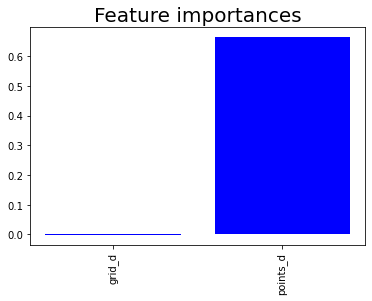

In [111]:
plt.bar(x=importances['Attribute'], height=importances['Importance'], color='blue')
plt.title('Feature importances', size=20)
plt.xticks(rotation='vertical')
plt.show()

Based on the logistic regression model, the number of points the driver has accumulated during the season and grid position at the start of the race influences 